# Menu <a class="anchor" id="menu"></a>
* [1. Exploratory Data Analysis (EDA)](#eda)
* [2. Experimenting various models](#models)
    * [2.0 Preparing the dataset](#models_prepare)
    * [2.1 Establishing a baseline with DummyClassifier](#models_dummy)
    * [2.2 Logistic Regression](#models_linear)
    * [2.3 Decision Tree](#models_decision_tree)
    * [2.4 Random Forest](#models_random_forest)
    * [2.5 XGBoost](#models_xgboost)
* [3. Impoving the models with GreadSearchCV](#models_grid)
    * [3.1 Logistic Regression Grid](#models_linear_grid)
    * [3.2 Decision Tree Grid](#models_decision_tree_grid)
    * [3.3 Random Forest Grid](#models_random_forest_grid)
    * [3.4 XGBoost Grid](#models_xgboost_grid)
* [4. Impoving the models with solutions for Imbalanced datasets](#models_balanced)
    * [4.1 Balanced Logistic Regression Grid](#models_linear_balanced)
    * [4.2 Balanced Decision Tree Grid](#models_decision_tree_balanced)
    * [4.3 Balanced Random Forest Grid](#models_random_forest_balanced)
    * [4.4 Balanced XGBoost Grid](#models_xgboost_balanced)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from zipfile import ZipFile

#### ---- Let's load the columns selected in the EDA ----

In [2]:
filename = 'data/dtypes_low.csv'

dtypes_df = pd.read_csv(filename, sep=',', index_col=0)

cols_to_keep = dtypes_df.columns
dtypes = dtypes_df.to_dict('records')[0]

#### \<test>

#### \<\test>

In [3]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [4]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

data_application_train.shape

(307511, 52)

#### \<test>

#### \<\test>

## Feature Engigeering

In [5]:
data_clean = data_application_train[:30000].copy()

In [6]:
import missingno as msno

# Experimenting various models <a class="anchor" id="models"></a> [⇪](#menu)

## 0. Preparing the dataset <a class="anchor" id="models_prepare"></a> [⇪](#menu)

### Splitting the dataset between `train`, `validation` and `test` sets

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_full = data_clean.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_clean['TARGET']

In [9]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.20,
                                                random_state=0,
                                                stratify=Y_full)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(
                                                X_train_full, 
                                                y_train_full, 
                                                test_size=X_test.shape[0], 
                                                random_state=0)

In [11]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((18000, 51), (18000,), (6000, 51), (6000,), (6000, 51), (6000,))

### Encoding the qualitative variables

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [13]:
oe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() == 2]
ohe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() > 2]

In [14]:
def fit_labels(data):
    """ Prepare the encoder for the ordinal columns.
    - Columns with 2 unique values are encoded using an OrdinalEncoder
    - Columns with more than 2 unique values are encoded using a OneHotEncoder
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    oe_targets = []
    ohe_targets = []
    
    for col in data.select_dtypes(exclude='number').columns:
        if data[col].nunique() == 2:
            oe_targets.append(col)
        else:
            ohe_targets.append(col)
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_mode):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

#### Fit the encoders

In [15]:
oe_model, ohe_model = fit_labels(X_train)

#### Transform the `training`, `validation` and `testing` sets

In [16]:
X_train = transform_labels(X_train, oe_model, ohe_model)
X_valid = transform_labels(X_valid, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

### Imputations

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [18]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    imputer = IterativeImputer(
        imputation_order='ascending', 
        random_state=0, 
        #min_value=0, 
        #max_value=max_values_imput
        n_nearest_features = 10,
    )
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    print(dt.shape, type(dt))
    
    return dt

In [19]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

In [20]:
X_train = impute(X_train, imputer_model)
X_valid = impute(X_valid, imputer_model)
X_test = impute(X_test, imputer_model)

(18000, 152) <class 'pandas.core.frame.DataFrame'>
(6000, 152) <class 'pandas.core.frame.DataFrame'>
(6000, 152) <class 'pandas.core.frame.DataFrame'>


<AxesSubplot:>

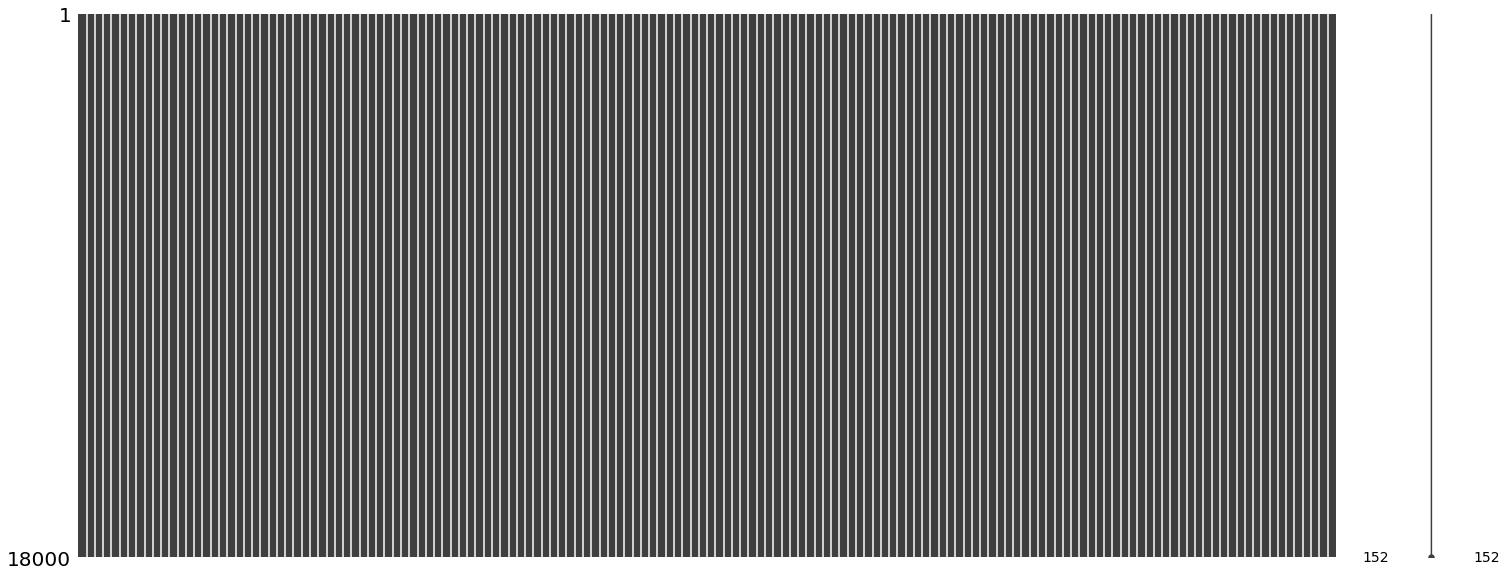

In [21]:
msno.matrix(X_train)

### Normalizing the dataset

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [23]:
def fit_normalizer(data):
    
    #minmax_scaler = MinMaxScaler(feature_range = (0, 1))
    #minmax_scaler.fit(data)
    
    #std_scaler = StandardScaler()
    #std_scaler.fit(data)
    
    #return minmax_scaler, std_scaler
    
    robust_scaler = RobustScaler()
    robust_scaler.fit(data)
    
    return robust_scaler

#def normalize(data, minmax_scaler, std_scaler):
def normalize(data, robust_scaler):
    
    dt = data.copy()
    #dt = pd.DataFrame(minmax_scaler.transform(dt), index=dt.index, columns=dt.columns)
    #dt = pd.DataFrame(std_scaler.transform(dt), index=dt.index, columns=dt.columns)
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

In [24]:
#normalizer_model, standardizer_model = fit_normalizer(X_train)
model_scaler = fit_normalizer(X_train)

In [25]:
#X_train = normalize(X_train, normalizer_model, standardizer_model)
#X_valid = normalize(X_valid, normalizer_model, standardizer_model)
#X_test = normalize(X_test, normalizer_model, standardizer_model)

X_train = normalize(X_train, model_scaler)
X_valid = normalize(X_valid, model_scaler)
X_test = normalize(X_test, model_scaler)

### Define some report functions

In [26]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score

In [27]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---\n\n", report)

In [28]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---\n")
    plt.show()

In [29]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None):
    
    print(f"--- ROC AUC ---\n")
    auc_scores = {}
    last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt

    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        alpha_v = 1 if i == last_index-1 else 0.5
        
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    return auc_scores

In [30]:
scores = pd.DataFrame(columns=['Method', 'ROC AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'TP', 'TN', 'FP', 'FN'])
y_preds = {}
scores_path = 'data/scores.csv'
scores.to_csv(scores_path, index=False)

def get_scores(method_name, y_true, y_pred, y_pred_proba, register=False, simple=False):
    
    rocauc_value = roc_auc_score(y_true, y_pred_proba)
    f1_value = f1_score(y_true, y_pred)
    accuracy_value = accuracy_score(y_true, y_pred)
    precision_value = precision_score(y_true, y_pred, zero_division=0)
    recall_value = recall_score(y_true, y_pred)
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    
    # Register score and replace if it already exists
    if register:
        idx = np.where(scores.Method == method_name)[0]        
        idx = idx[0] if idx.size > 0 else len(scores.index)
        scores.loc[idx] = [method_name, rocauc_value, f1_value, accuracy_value, precision_value, recall_value, TP, TN, FP, FN]
        
        scores.to_csv(scores_path, index=False)
    
    # Basic report
    print(f"--- {method_name} ---\n\nROC AUC:{rocauc_value}\nF1-score:{f1_value}\nRecall:{recall_value}\n")
    
    if simple:
        return
    
    # Classification report
    print_classification_report(y_true, y_pred)
    
    # Confusion Matrix
    print_confusion_matrix(y_true, y_pred)
    
    # ROC AUC curves
    y_preds[method_name] = y_pred_proba
    print_rocauc(y_true, y_preds)

In [31]:
def find_best_threshold(model, X_valid, y_valid, eval_function ):
    
    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = [ 1 if x > threshold else 0 for x in y_pred_proba]
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_threshold:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

## 1. Establishing baseline with Dummy Classifier <a class="anchor" id="models_dummy"></a> [⇪](#menu)

In [32]:
from sklearn.dummy import DummyClassifier

In [33]:
clf_dummy = DummyClassifier(strategy='stratified', random_state=0)
clf_dummy.fit(X_train, y_train)

DummyClassifier(random_state=0, strategy='stratified')

--- Dummy ---

ROC AUC:0.49805566783280136
F1-score:0.07676348547717843
Recall:0.07692307692307693

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.92      0.92      5519
Prediction = 1       0.08      0.08      0.08       481

      accuracy                           0.85      6000
     macro avg       0.50      0.50      0.50      6000
  weighted avg       0.85      0.85      0.85      6000

--- Confusion Matrix ---



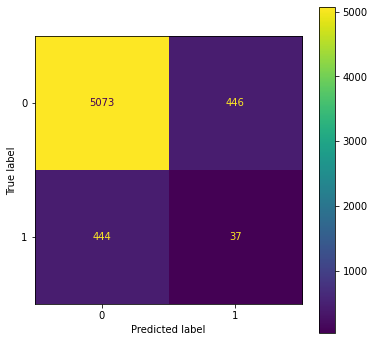

--- ROC AUC ---



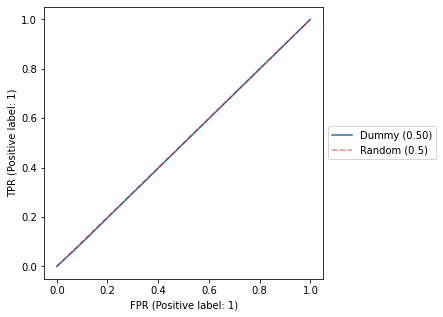

In [34]:
y_pred_dummy = clf_dummy.predict(X_test)
y_pred_proba_dummy = clf_dummy.predict_proba(X_test)[:,1]

get_scores("Dummy", y_test, y_pred_dummy, y_pred_proba_dummy, register=True)

> - The **recall** means "how many of this class you find over the whole number of element of this class"
> - The **precision** will be "how many are correctly classified among that class"
> - The **f1-score** is the harmonic mean between precision & recall
> - The **support** is the number of occurence of the given class in your dataset


## 2. Logistic Regression <a class="anchor" id="models_linear"></a> [⇪](#menu)

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
clf_log = LogisticRegression(C=0.1, random_state=0)
clf_log.fit(X_train, y_train)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, random_state=0)

--- Basic RegLog ---

ROC AUC:0.7349586892982436
F1-score:0.004123711340206186
Recall:0.002079002079002079

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.25      0.00      0.00       481

      accuracy                           0.92      6000
     macro avg       0.58      0.50      0.48      6000
  weighted avg       0.87      0.92      0.88      6000

--- Confusion Matrix ---



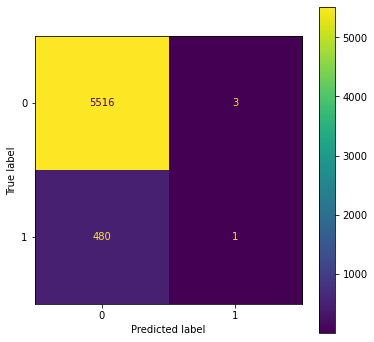

--- ROC AUC ---



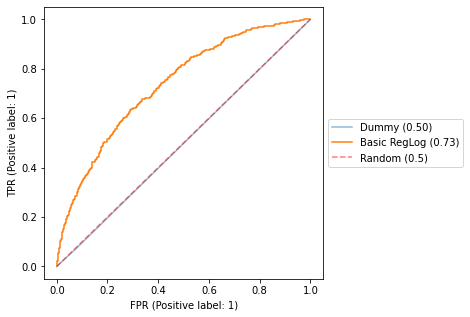

In [37]:
y_pred_log = clf_log.predict(X_test)
y_pred_proba_log = clf_log.predict_proba(X_test)[:,1]

get_scores("Basic RegLog", y_test, y_pred_log, y_pred_proba_log, register=True)

#### Let's find the best threshold

In [38]:
f1_value, best_threshold = find_best_threshold(clf_log, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2554945054945055) for this model is reached with a threshold of 0.253


--- Basic RegLog with 0.253 threshold ---

ROC AUC:0.7349586892982436
F1-score:0.2099125364431487
Recall:0.1496881496881497

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.98      0.95      5519
Prediction = 1       0.35      0.15      0.21       481

      accuracy                           0.91      6000
     macro avg       0.64      0.56      0.58      6000
  weighted avg       0.88      0.91      0.89      6000

--- Confusion Matrix ---



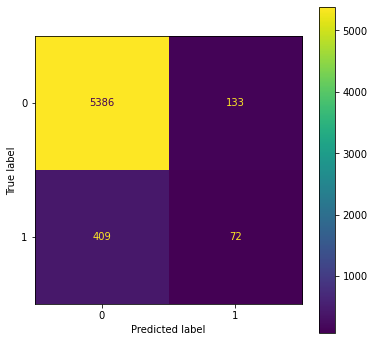

--- ROC AUC ---



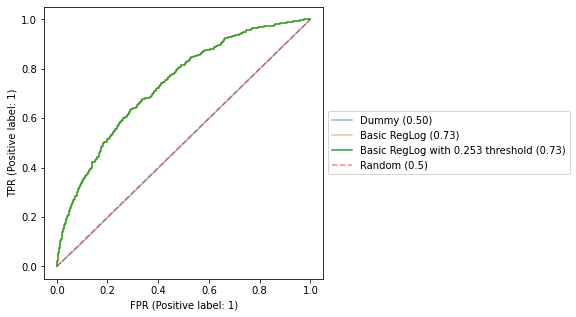

In [39]:
y_pred_proba_log = clf_log.predict_proba(X_test)[:,1]
y_pred_log = [ 1 if x > best_threshold else 0 for x in y_pred_proba_log]

get_scores(f"Basic RegLog with {best_threshold} threshold", y_test, y_pred_log, y_pred_proba_log, register=True)

## 3. Decision Tree <a class="anchor" id="models_decision_tree"></a> [⇪](#menu)

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

--- Basic Decision Tree ---

ROC AUC:0.5451955991002919
F1-score:0.16318407960199008
Recall:0.1704781704781705

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.92      0.92      5519
Prediction = 1       0.16      0.17      0.16       481

      accuracy                           0.86      6000
     macro avg       0.54      0.55      0.54      6000
  weighted avg       0.87      0.86      0.86      6000

--- Confusion Matrix ---



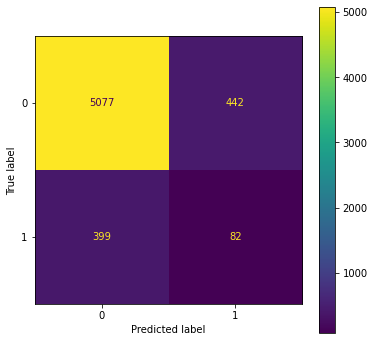

--- ROC AUC ---



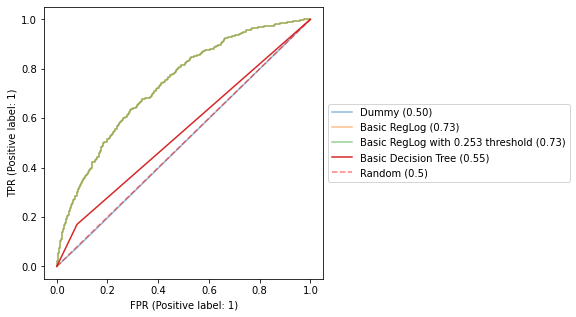

In [42]:
y_pred_dt = clf_dt.predict(X_test)
y_pred_proba_dt = clf_dt.predict_proba(X_test)[:,1]

get_scores("Basic Decision Tree", y_test, y_pred_dt, y_pred_proba_dt, register=True)

#### Let's find the best threshold

In [43]:
f1_value, best_threshold = find_best_threshold(clf_dt, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.17924528301886797) for this model is reached with a threshold of 0.18


--- Basic Decision Tree with 0.18 threshold ---

ROC AUC:0.5451955991002919
F1-score:0.16318407960199008
Recall:0.1704781704781705

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.92      0.92      5519
Prediction = 1       0.16      0.17      0.16       481

      accuracy                           0.86      6000
     macro avg       0.54      0.55      0.54      6000
  weighted avg       0.87      0.86      0.86      6000

--- Confusion Matrix ---



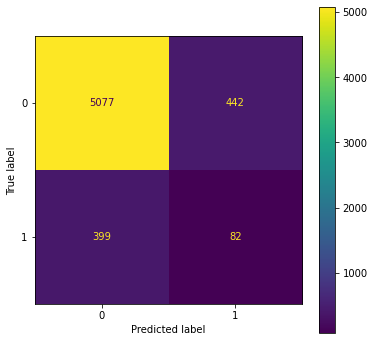

--- ROC AUC ---



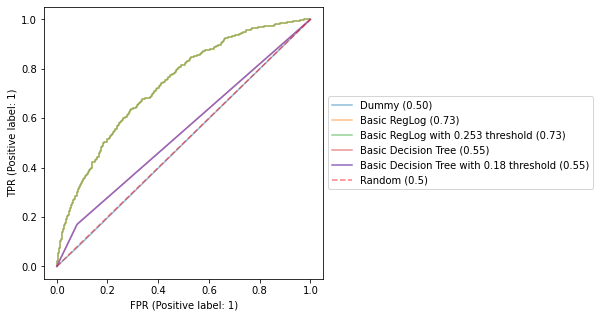

In [44]:
y_pred_proba_dt = clf_dt.predict_proba(X_test)[:,1]
y_pred_dt = [ 1 if x > best_threshold else 0 for x in y_pred_proba_dt]

get_scores(f"Basic Decision Tree with {best_threshold} threshold", y_test, y_pred_dt, y_pred_proba_dt, register=True)

## 4. Random Forest <a class="anchor" id="models_random_forest"></a> [⇪](#menu)

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1, min_samples_split=100)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=100, n_jobs=-1, random_state=0)

--- Basic Random Forest ---

ROC AUC:0.7144278374573718
F1-score:0.24839006439742412
Recall:0.5613305613305614

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.74      0.83      5519
Prediction = 1       0.16      0.56      0.25       481

      accuracy                           0.73      6000
     macro avg       0.56      0.65      0.54      6000
  weighted avg       0.89      0.73      0.79      6000

--- Confusion Matrix ---



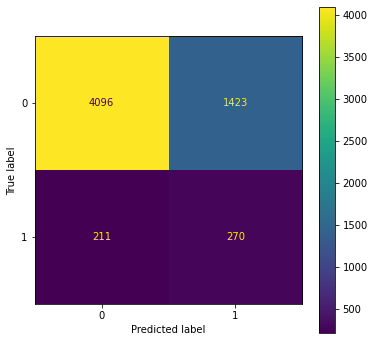

--- ROC AUC ---



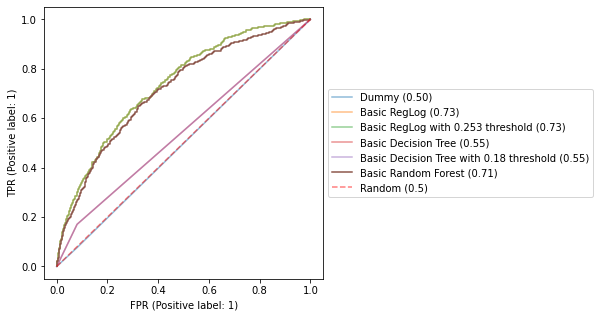

In [47]:
y_pred_rf = clf_rf.predict(X_test)
y_pred_proba_rf = clf_rf.predict_proba(X_test)[:,1]

y_pred_rf = [ 1 if x > 0.10 else 0 for x in y_pred_proba_rf]

get_scores("Basic Random Forest", y_test, y_pred_rf, y_pred_proba_rf, register=True)

#### Let's find the best threshold

In [48]:
f1_value, best_threshold = find_best_threshold(clf_rf, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.21605839416058392) for this model is reached with a threshold of 0.216


--- Basic Random Forest with 0.216 threshold ---

ROC AUC:0.7144278374573718
F1-score:0.16459627329192547
Recall:0.1101871101871102

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.98      0.95      5519
Prediction = 1       0.33      0.11      0.16       481

      accuracy                           0.91      6000
     macro avg       0.63      0.55      0.56      6000
  weighted avg       0.88      0.91      0.89      6000

--- Confusion Matrix ---



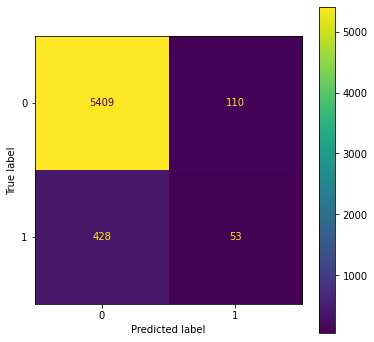

--- ROC AUC ---



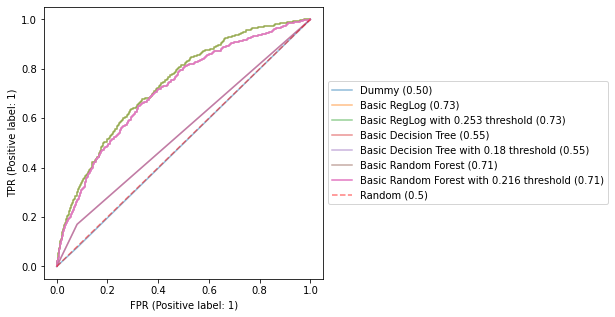

In [49]:
y_pred_proba_rf = clf_rf.predict_proba(X_test)[:,1]
y_pred_rf = [ 1 if x > best_threshold else 0 for x in y_pred_proba_rf]

get_scores(f"Basic Random Forest with {best_threshold} threshold", y_test, y_pred_rf, y_pred_proba_rf, register=True)

## 5. XGBoost Classifier <a class="anchor" id="models_xgboost"></a> [⇪](#menu)

In [50]:
from xgboost import XGBClassifier

In [51]:
clf_xgb = XGBClassifier(
    # max_depth=6,
    # min_child_weight=1,
    objective='binary:logistic', # classification
    eval_metric='auc', # classification
    nthread=-1,
    seed=0,
    verbosity=1
)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

--- Basic XGBoost ---

ROC AUC:0.6913160320480487
F1-score:0.03501945525291829
Recall:0.018711018711018712

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.27      0.02      0.04       481

      accuracy                           0.92      6000
     macro avg       0.60      0.51      0.50      6000
  weighted avg       0.87      0.92      0.88      6000

--- Confusion Matrix ---



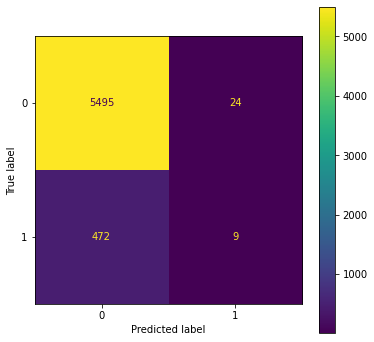

--- ROC AUC ---



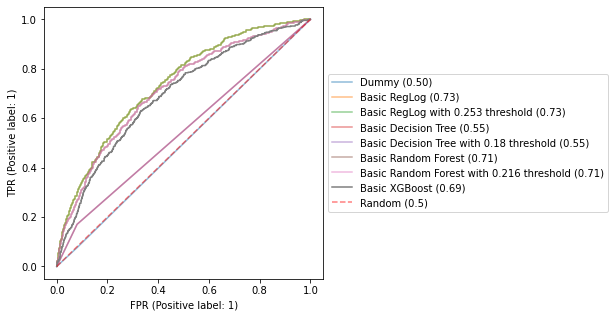

In [52]:
y_pred_xgb = clf_xgb.predict(X_test)
y_pred_proba_xgb = clf_xgb.predict_proba(X_test)[:,1]

get_scores("Basic XGBoost", y_test, y_pred_xgb, y_pred_proba_xgb, register=True)

#### Let's find the best threshold

In [53]:
f1_value, best_threshold = find_best_threshold(clf_xgb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.22143698468786807) for this model is reached with a threshold of 0.233


--- Basic XGBoost with 0.233 threshold ---

ROC AUC:0.6913160320480487
F1-score:0.17220172201722017
Recall:0.14553014553014554

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.95      0.94      5519
Prediction = 1       0.21      0.15      0.17       481

      accuracy                           0.89      6000
     macro avg       0.57      0.55      0.56      6000
  weighted avg       0.87      0.89      0.88      6000

--- Confusion Matrix ---



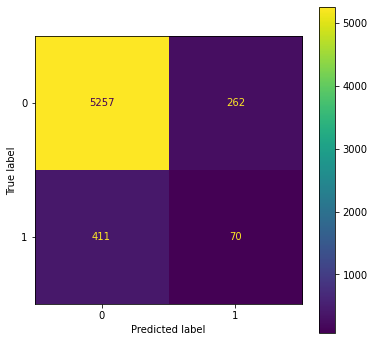

--- ROC AUC ---



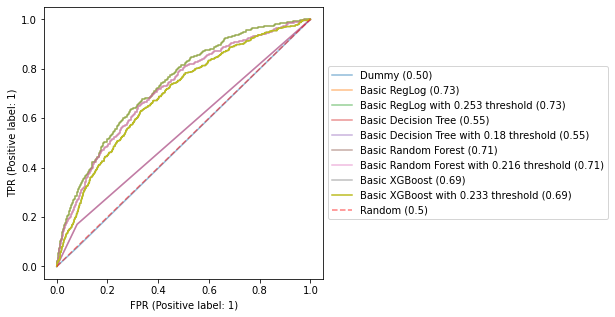

In [54]:
y_pred_proba_xgb = clf_xgb.predict_proba(X_test)[:,1]
y_pred_xgb = [ 1 if x > best_threshold else 0 for x in y_pred_proba_xgb]

get_scores(f"Basic XGBoost with {best_threshold} threshold", y_test, y_pred_xgb, y_pred_proba_xgb, register=True)

## 6. Review scores <a class="anchor" id="models_scores"></a> [⇪](#menu)

In [55]:
scores

,Method,ROC AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN
0,Dummy,0.498056,0.076763,0.851667,0.076605,0.076923,37,5073,446,444
1,Basic RegLog,0.734959,0.004124,0.919500,0.250000,0.002079,1,5516,3,480
2,Basic RegLog with 0.253 threshold,0.734959,0.209913,0.909667,0.351220,0.149688,72,5386,133,409
3,Basic Decision Tree,0.545196,0.163184,0.859833,0.156489,0.170478,82,5077,442,399
4,Basic Decision Tree with 0.18 threshold,0.545196,0.163184,0.859833,0.156489,0.170478,82,5077,442,399
5,Basic Random Forest,0.714428,0.248390,0.727667,0.159480,0.561331,270,4096,1423,211
6,Basic Random Forest with 0.216 threshold,0.714428,0.164596,0.910333,0.325153,0.110187,53,5409,110,428
7,Basic XGBoost,0.691316,0.035019,0.917333,0.272727,0.018711,9,5495,24,472
8,Basic XGBoost with 0.233 threshold,0.691316,0.172202,0.887833,0.210843,0.145530,70,5257,262,411


In [56]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']]

,Method,ROC AUC,F1 score,Recall
0,Dummy,0.498056,0.076763,0.076923
1,Basic RegLog,0.734959,0.004124,0.002079
2,Basic RegLog with 0.253 threshold,0.734959,0.209913,0.149688
3,Basic Decision Tree,0.545196,0.163184,0.170478
4,Basic Decision Tree with 0.18 threshold,0.545196,0.163184,0.170478
5,Basic Random Forest,0.714428,0.248390,0.561331
6,Basic Random Forest with 0.216 threshold,0.714428,0.164596,0.110187
7,Basic XGBoost,0.691316,0.035019,0.018711
8,Basic XGBoost with 0.233 threshold,0.691316,0.172202,0.145530


# Improving the models with GridSearchCV <a class="anchor" id="models_grid"></a> [⇪](#menu)

In [57]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

In [58]:
X_train_full = transform_labels(X_train_full, oe_model, ohe_model)
X_train_full = impute(X_train_full, imputer_model)
X_train_full = normalize(X_train_full, model_scaler)

num_samples = 10000
X_train_full = X_train_full[:num_samples]
y_train_full = y_train_full[:num_samples]

(24000, 152) <class 'pandas.core.frame.DataFrame'>


In [59]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

## 1. Logistic Regression Grid<a class="anchor" id="models_linear_grid"></a> [⇪](#menu)

In [60]:
param_grid = [
    {
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['saga'],
        'penalty' : ['l1', 'l2', 'elasticnet'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]


In [61]:
clf_log_model = LogisticRegression(max_iter=1000, random_state=0)

In [62]:
clf_log_grid = GridSearchCV(clf_log_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
#clf_log_grid.fit(X_train_full, y_train_full)
clf_log_grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
             estimator=LogisticRegression(max_iter=1000, random_state=0),
             n_jobs=-1,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['saga']}],
             scoring='roc_auc', verbose=1)

In [63]:
clf_log_grid.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

In [64]:
y_pred_log_grid = clf_log_grid.predict(X_test)
y_pred_proba_log_grid = clf_log_grid.predict_proba(X_test)[:,1]
get_scores("Grid LogReg", y_test, y_pred_log_grid, y_pred_proba_log_grid, register=False, simple=True)

--- Grid LogReg ---

ROC AUC:0.7387863283858934
F1-score:0.004123711340206186
Recall:0.002079002079002079



#### Let's find the best threshold

In [65]:
f1_value, best_threshold = find_best_threshold(clf_log_grid, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.24933687002652521) for this model is reached with a threshold of 0.25


#### We train a new model using the best parameters

In [66]:
clf_log2 = LogisticRegression( **clf_log_grid.best_params_, random_state=0, max_iter=1000 )
#clf_log2.fit(X_train_full, y_train_full)
clf_log2.fit(X_train, y_train)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=0,
                   solver='saga')

--- Grid LogReg ---

ROC AUC:0.738148200188425
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.00      0.00      0.00       481

      accuracy                           0.92      6000
     macro avg       0.46      0.50      0.48      6000
  weighted avg       0.85      0.92      0.88      6000

--- Confusion Matrix ---



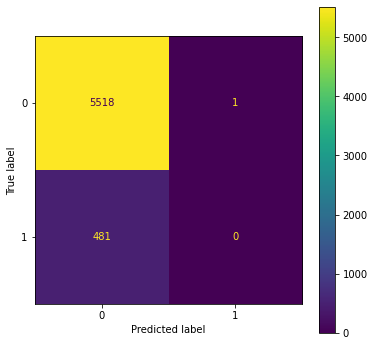

--- ROC AUC ---



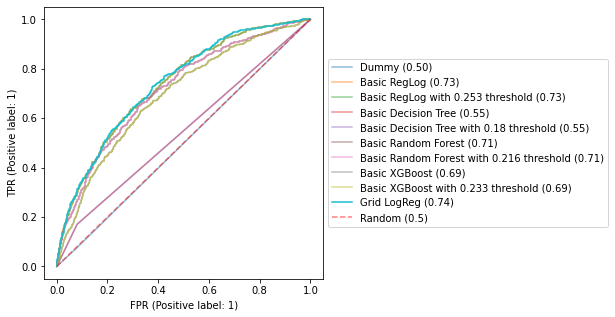

In [67]:
y_pred_log_grid = clf_log2.predict(X_test)
y_pred_proba_log_grid = clf_log2.predict_proba(X_test)[:,1]

get_scores("Grid LogReg", y_test, y_pred_log_grid, y_pred_proba_log_grid, register=True)

#### Let's use the best threshold

--- Grid LogReg with 0.25 threshold ---

ROC AUC:0.738148200188425
F1-score:0.1875
Recall:0.13097713097713098

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.98      0.95      5519
Prediction = 1       0.33      0.13      0.19       481

      accuracy                           0.91      6000
     macro avg       0.63      0.55      0.57      6000
  weighted avg       0.88      0.91      0.89      6000

--- Confusion Matrix ---



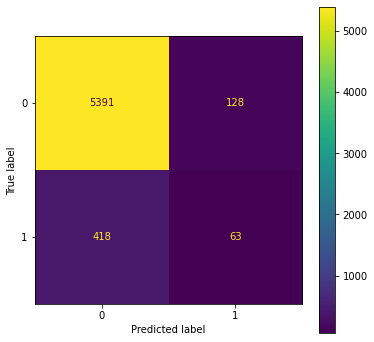

--- ROC AUC ---



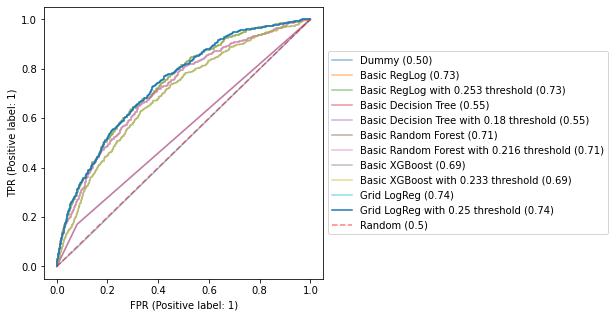

In [68]:
y_pred_proba_log_grid = clf_log2.predict_proba(X_test)[:,1]
y_pred_log_grid = [ 1 if x > best_threshold else 0 for x in y_pred_proba_log_grid]

get_scores(f"Grid LogReg with {best_threshold} threshold", y_test, y_pred_log_grid, y_pred_proba_log_grid, register=True)

## 2. Decision Tree Grid <a class="anchor" id="models_decision_tree_grid"></a> [⇪](#menu)

In [69]:
param_grid = {
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
    'criterion' :['gini', 'entropy']
}

In [70]:
clf_dt_model = DecisionTreeClassifier(random_state=0)

In [71]:
clf_dt_grid = GridSearchCV(clf_dt_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
#clf_dt_grid.fit(X_train_full, y_train_full)
clf_dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [None, 'auto', 'sqrt', 'log2']},
             scoring='roc_auc', verbose=1)

In [72]:
clf_dt_grid.best_params_

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None}

In [73]:
y_pred_dt_grid = clf_dt_grid.predict(X_test)
y_pred_proba_dt_grid = clf_dt_grid.predict_proba(X_test)[:,1]

get_scores("Grid Decision Tree", y_test, y_pred_dt_grid, y_pred_proba_dt_grid, register=False, simple=True)

--- Grid Decision Tree ---

ROC AUC:0.6879319560964787
F1-score:0.008113590263691683
Recall:0.004158004158004158



#### Let's find the best threshold

In [74]:
f1_value, best_threshold = find_best_threshold(clf_dt_grid, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.26706231454005935) for this model is reached with a threshold of 0.246


#### We train a new model using the best parameters

In [75]:
clf_dt2 = DecisionTreeClassifier( **clf_dt_grid.best_params_, random_state=0 )
#clf_dt2.fit(X_train_full, y_train_full)
clf_dt2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=5,
                       random_state=0)

--- Grid Decision Tree ---

ROC AUC:0.6945499934266015
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.00      0.00      0.00       481

      accuracy                           0.92      6000
     macro avg       0.46      0.50      0.48      6000
  weighted avg       0.85      0.92      0.88      6000

--- Confusion Matrix ---



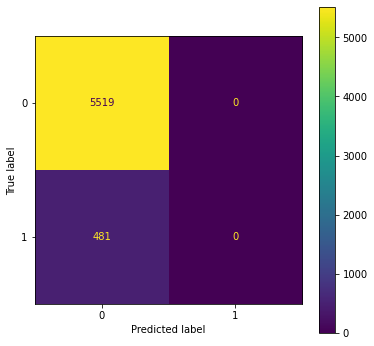

--- ROC AUC ---



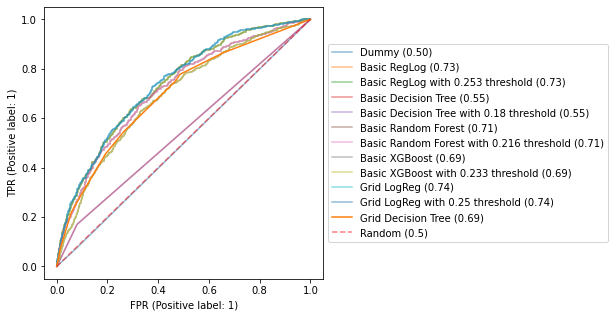

In [76]:
y_pred_dt_grid = clf_dt2.predict(X_test)
y_pred_proba_dt_grid = clf_dt2.predict_proba(X_test)[:,1]

get_scores("Grid Decision Tree", y_test, y_pred_dt_grid, y_pred_proba_dt_grid, register=True)

#### Let's use the best threshold

--- Grid Decision Tree with 0.246 threshold ---

ROC AUC:0.6945499934266015
F1-score:0.11544991511035656
Recall:0.07068607068607069

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.95      5519
Prediction = 1       0.31      0.07      0.12       481

      accuracy                           0.91      6000
     macro avg       0.62      0.53      0.53      6000
  weighted avg       0.88      0.91      0.89      6000

--- Confusion Matrix ---



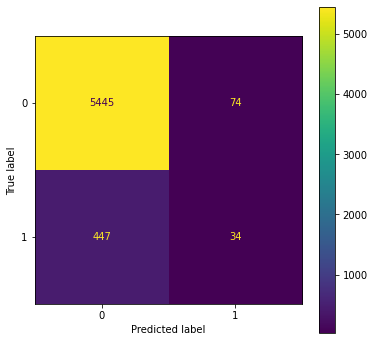

--- ROC AUC ---



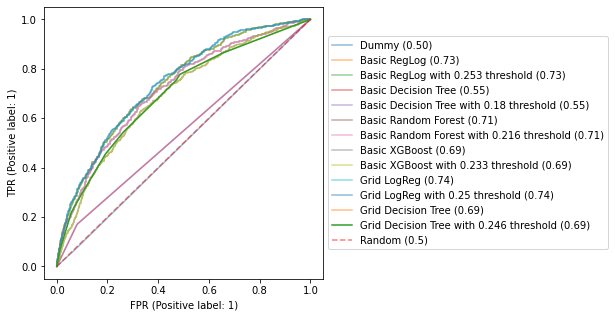

In [77]:
y_pred_proba_dt_grid = clf_dt2.predict_proba(X_test)[:,1]
y_pred_dt_grid = [ 1 if x > best_threshold else 0 for x in y_pred_proba_dt_grid]

get_scores(f"Grid Decision Tree with {best_threshold} threshold", y_test, y_pred_dt_grid, y_pred_proba_dt_grid, register=True)

## 3. Random Forest Grid <a class="anchor" id="models_random_forest_grid"></a> [⇪](#menu)

In [78]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    'n_estimators' :[64, 100, 128, 256, 528]
}

In [79]:
clf_rf_model = RandomForestClassifier(random_state=0)

In [80]:
clf_rf_grid = GridSearchCV(clf_rf_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
#clf_rf_grid.fit(X_train_full, y_train_full)
clf_rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [64, 100, 128, 256, 528]},
             scoring='roc_auc', verbose=1)

In [81]:
clf_rf_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 528}

In [82]:
y_pred_rf_grid = clf_rf_grid.predict(X_test)
y_pred_proba_rf_grid = clf_rf_grid.predict_proba(X_test)[:,1]
get_scores("Grid Random Forest", y_test, y_pred_rf_grid, y_pred_proba_rf_grid, register=False, simple=True)

--- Grid Random Forest ---

ROC AUC:0.7235827545666285
F1-score:0.0
Recall:0.0



#### Let's find the best threshold

In [83]:
f1_value, best_threshold = find_best_threshold(clf_rf_grid, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.19047619047619044) for this model is reached with a threshold of 0.187


#### We train a new model using the best parameters

In [84]:
clf_rf2 = RandomForestClassifier( **clf_rf_grid.best_params_, random_state=0 )
#clf_rf2.fit(X_train_full, y_train_full)
clf_rf2.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=528,
                       random_state=0)

--- Grid Random Forest ---

ROC AUC:0.72987023847687
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.00      0.00      0.00       481

      accuracy                           0.92      6000
     macro avg       0.46      0.50      0.48      6000
  weighted avg       0.85      0.92      0.88      6000

--- Confusion Matrix ---



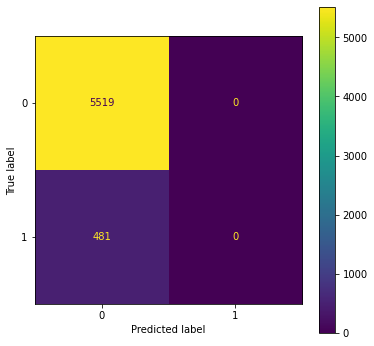

--- ROC AUC ---



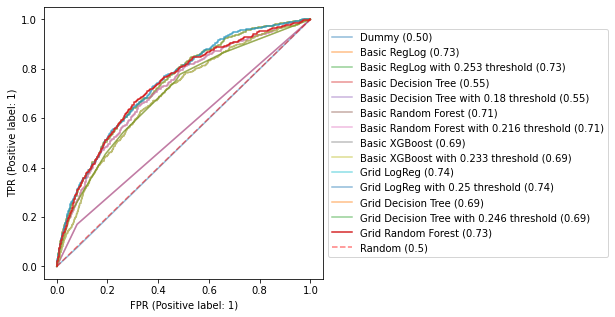

In [85]:
y_pred_rf_grid = clf_rf2.predict(X_test)
y_pred_proba_rf_grid = clf_rf2.predict_proba(X_test)[:,1]

get_scores("Grid Random Forest", y_test, y_pred_rf_grid, y_pred_proba_rf_grid, register=True)

#### Let's use the best threshold

--- Grid Random Forest with 0.187 threshold ---

ROC AUC:0.72987023847687
F1-score:0.17204301075268816
Recall:0.11642411642411643

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.98      0.95      5519
Prediction = 1       0.33      0.12      0.17       481

      accuracy                           0.91      6000
     macro avg       0.63      0.55      0.56      6000
  weighted avg       0.88      0.91      0.89      6000

--- Confusion Matrix ---



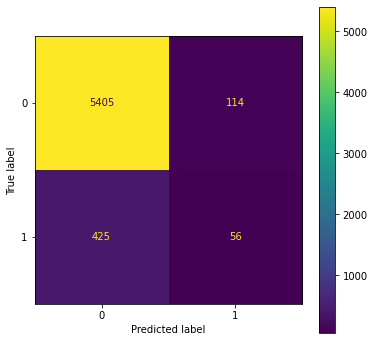

--- ROC AUC ---



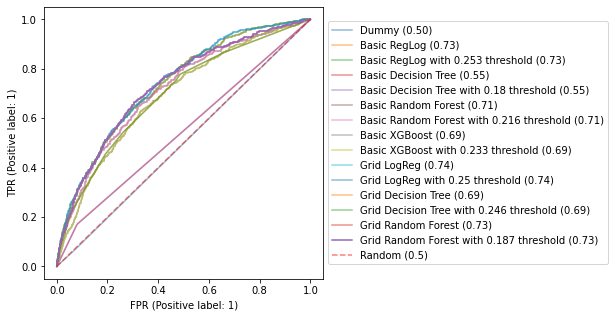

In [86]:
y_pred_proba_rf_grid = clf_rf2.predict_proba(X_test)[:,1]
y_pred_rf_grid = [ 1 if x > best_threshold else 0 for x in y_pred_proba_rf_grid]

get_scores(f"Grid Random Forest with {best_threshold} threshold", y_test, y_pred_rf_grid, y_pred_proba_rf_grid, register=True)

## 4. XGBoost Classifier Grid<a class="anchor" id="models_xgboost_grid"></a> [⇪](#menu)

In [87]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [88]:
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [89]:
clf_xgb_model = XGBClassifier(
    # max_depth=6,
    # min_child_weight=1,
    objective='binary:logistic', # classification
    eval_metric='auc', # classification
    nthread=-1,
    seed=0,
    verbosity=1
)

In [90]:
clf_xgb_grid = RandomizedSearchCV(clf_xgb_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
#clf_xgb_grid.fit(X_train_full, y_train_full)
clf_xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc', gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
      

In [91]:
clf_xgb_grid.best_params_

{'n_estimators': 140, 'max_depth': 2, 'learning_rate': 0.1}

In [92]:
y_pred_xgb_grid = clf_xgb_grid.predict(X_test)
y_pred_proba_xgb_grid = clf_xgb_grid.predict_proba(X_test)[:,1]

get_scores("Grid GXBoost", y_test, y_pred_xgb_grid, y_pred_proba_xgb_grid, register=False, simple=True)

--- Grid GXBoost ---

ROC AUC:0.7390225186927488
F1-score:0.004123711340206186
Recall:0.002079002079002079



#### Let's find the best threshold

In [93]:
f1_value, best_threshold = find_best_threshold(clf_xgb_grid, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2437673130193906) for this model is reached with a threshold of 0.245


#### We train a new model using the best parameters

In [94]:
clf_xgb2 = XGBClassifier(
    # max_depth=6,
    # min_child_weight=1,
    objective='binary:logistic', # classification
    eval_metric='auc', # classification
    nthread=-1,
    seed=0,
    verbosity=1,
    **clf_xgb_grid.best_params_, 
)

#clf_xgb2.fit(X_train_full, y_train_full)
clf_xgb2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=140,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

--- Grid XGBoost ---

ROC AUC:0.7384339264208806
F1-score:0.01639344262295082
Recall:0.008316008316008316

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.57      0.01      0.02       481

      accuracy                           0.92      6000
     macro avg       0.75      0.50      0.49      6000
  weighted avg       0.89      0.92      0.88      6000

--- Confusion Matrix ---



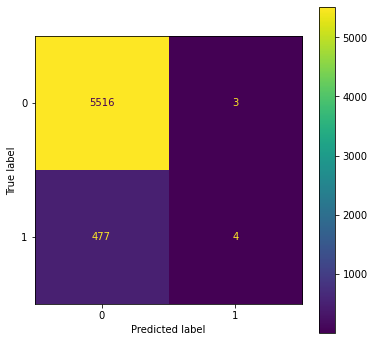

--- ROC AUC ---



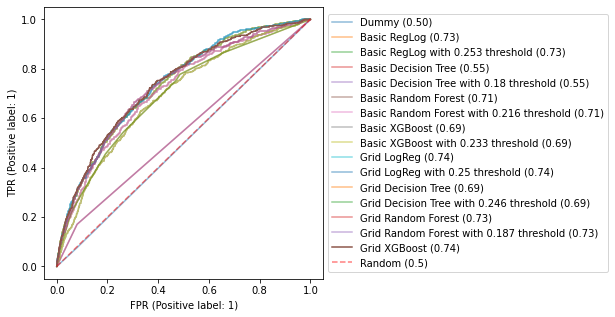

In [95]:
y_pred_xgb_grid = clf_xgb2.predict(X_test)
y_pred_proba_xgb_grid = clf_xgb2.predict_proba(X_test)[:,1]

get_scores("Grid XGBoost", y_test, y_pred_xgb_grid, y_pred_proba_xgb_grid, register=True)

#### Let's use the best threshold

--- Grid XGBoost with 0.245 threshold ---

ROC AUC:0.7384339264208806
F1-score:0.22371967654986524
Recall:0.17255717255717257

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.97      0.95      5519
Prediction = 1       0.32      0.17      0.22       481

      accuracy                           0.90      6000
     macro avg       0.62      0.57      0.59      6000
  weighted avg       0.88      0.90      0.89      6000

--- Confusion Matrix ---



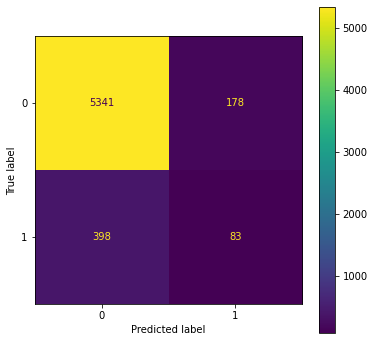

--- ROC AUC ---



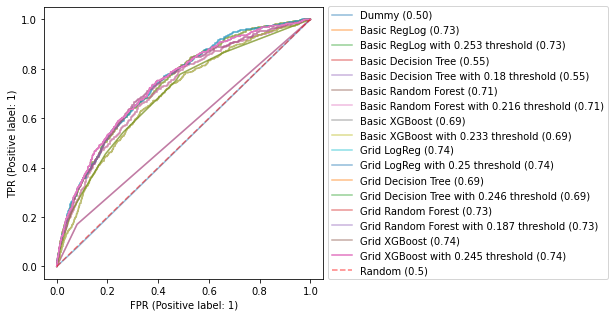

In [96]:
y_pred_proba_xgb_grid = clf_xgb2.predict_proba(X_test)[:,1]
y_pred_xgb_grid = [ 1 if x > best_threshold else 0 for x in y_pred_proba_xgb_grid]

get_scores(f"Grid XGBoost with {best_threshold} threshold", y_test, y_pred_xgb_grid, y_pred_proba_xgb_grid, register=True)

## 5. Review scores <a class="anchor" id="models_grid_scores"></a> [⇪](#menu)

In [97]:
scores

,Method,ROC AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN
0,Dummy,0.498056,0.076763,0.851667,0.076605,0.076923,37,5073,446,444
1,Basic RegLog,0.734959,0.004124,0.919500,0.250000,0.002079,1,5516,3,480
2,Basic RegLog with 0.253 threshold,0.734959,0.209913,0.909667,0.351220,0.149688,72,5386,133,409
3,Basic Decision Tree,0.545196,0.163184,0.859833,0.156489,0.170478,82,5077,442,399
4,Basic Decision Tree with 0.18 threshold,0.545196,0.163184,0.859833,0.156489,0.170478,82,5077,442,399
5,Basic Random Forest,0.714428,0.248390,0.727667,0.159480,0.561331,270,4096,1423,211
6,Basic Random Forest with 0.216 threshold,0.714428,0.164596,0.910333,0.325153,0.110187,53,5409,110,428
7,Basic XGBoost,0.691316,0.035019,0.917333,0.272727,0.018711,9,5495,24,472
8,Basic XGBoost with 0.233 threshold,0.691316,0.172202,0.887833,0.210843,0.145530,70,5257,262,411
9,Grid LogReg,0.738148,0.000000,0.919667,0.000000,0.000000,0,5518,1,481


In [98]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('Recall', ascending=False)

,Method,ROC AUC,F1 score,Recall
5,Basic Random Forest,0.714428,0.248390,0.561331
16,Grid XGBoost with 0.245 threshold,0.738434,0.223720,0.172557
3,Basic Decision Tree,0.545196,0.163184,0.170478
4,Basic Decision Tree with 0.18 threshold,0.545196,0.163184,0.170478
2,Basic RegLog with 0.253 threshold,0.734959,0.209913,0.149688
8,Basic XGBoost with 0.233 threshold,0.691316,0.172202,0.145530
10,Grid LogReg with 0.25 threshold,0.738148,0.187500,0.130977
14,Grid Random Forest with 0.187 threshold,0.729870,0.172043,0.116424
6,Basic Random Forest with 0.216 threshold,0.714428,0.164596,0.110187
0,Dummy,0.498056,0.076763,0.076923


# Impoving the models with solutions for Imbalanced datasets <a class="anchor" id="models_balanced"></a> [⇪](#menu)

## 1. Balanced Logistic Regression Grid<a class="anchor" id="models_linear_balanced"></a> [⇪](#menu)

In [99]:
param_grid = [
    {
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['saga'],
        'penalty' : ['l1', 'l2', 'elasticnet'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [100]:
clf_log_model_imb = LogisticRegression(max_iter=1000, random_state=0, class_weight='balanced')

In [101]:
clf_log_imb = GridSearchCV(clf_log_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
#clf_log_imb.fit(X_train_full, y_train_full)
clf_log_imb.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=0),
             n_jobs=-1,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['saga']}],
             scoring='roc_auc', verbose=1)

In [102]:
clf_log_imb.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}

In [103]:
y_pred_log_imb = clf_log_imb.predict(X_test)
y_pred_proba_log_imb = clf_log_imb.predict_proba(X_test)[:,1]
get_scores("Balanced LogReg", y_test, y_pred_log_imb, y_pred_proba_log_imb, register=False, simple=True)

--- Balanced LogReg ---

ROC AUC:0.7392022041415047
F1-score:0.24778761061946905
Recall:0.6694386694386695



#### Let's find the best threshold

In [104]:
f1_value, best_threshold = find_best_threshold(clf_log_imb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.30453108535300316) for this model is reached with a threshold of 0.579


#### We train a new model using the best parameters

In [105]:
clf_log_imb2 = LogisticRegression( **clf_log_imb.best_params_, max_iter=1000, random_state=0, class_weight='balanced')

--- Balanced LogReg ---

ROC AUC:0.7390308060719368
F1-score:0.2490211433046202
Recall:0.6611226611226612

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.80      5519
Prediction = 1       0.15      0.66      0.25       481

      accuracy                           0.68      6000
     macro avg       0.56      0.67      0.52      6000
  weighted avg       0.89      0.68      0.75      6000

--- Confusion Matrix ---



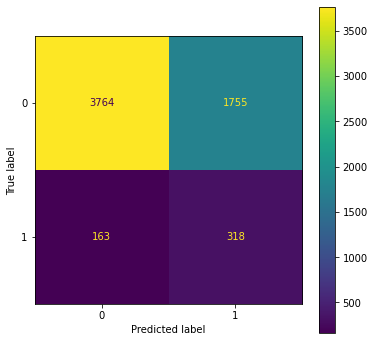

--- ROC AUC ---



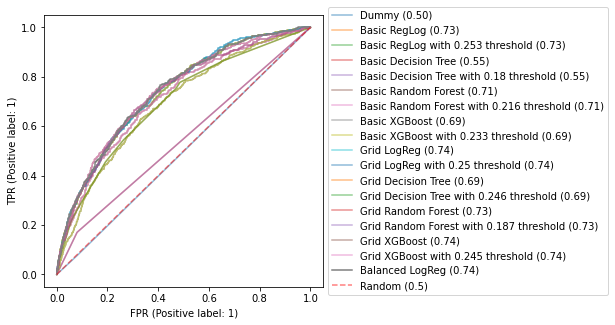

In [106]:
#clf_log_imb2.fit(X_train_full, y_train_full)
clf_log_imb2.fit(X_train, y_train)
y_pred_log_imb = clf_log_imb2.predict(X_test)
y_pred_proba_log_imb = clf_log_imb2.predict_proba(X_test)[:,1]

get_scores("Balanced LogReg", y_test, y_pred_log_imb, y_pred_proba_log_imb, register=True)

#### Let's use the best threshold

--- Balanced LogReg with 0.579 threshold ---

ROC AUC:0.7392022041415047
F1-score:0.2694136291600634
Recall:0.5301455301455301

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.79      0.86      5519
Prediction = 1       0.18      0.53      0.27       481

      accuracy                           0.77      6000
     macro avg       0.57      0.66      0.57      6000
  weighted avg       0.89      0.77      0.82      6000

--- Confusion Matrix ---



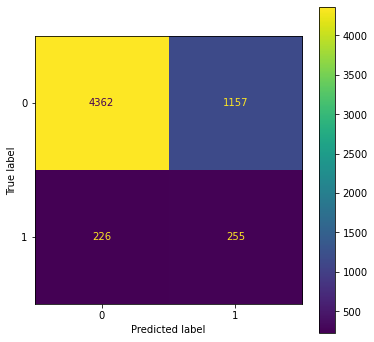

--- ROC AUC ---



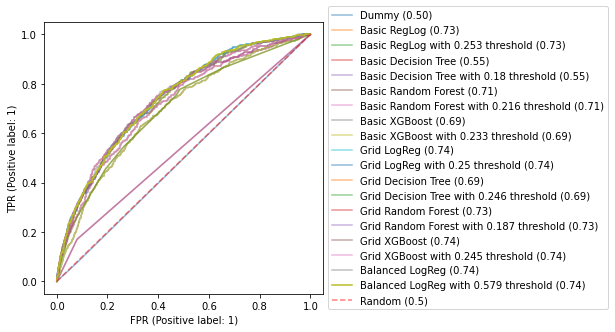

In [107]:
y_pred_proba_log_imb = clf_log_imb.predict_proba(X_test)[:,1]
y_pred_log_imb = [ 1 if x > best_threshold else 0 for x in y_pred_proba_log_imb]

get_scores(f"Balanced LogReg with {best_threshold} threshold", y_test, y_pred_log_imb, y_pred_proba_log_imb, register=True)

## 2. Balanced Decision Tree Grid <a class="anchor" id="models_decision_tree_balanced"></a> [⇪](#menu)

In [108]:
param_grid = {
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
    'criterion' :['gini', 'entropy']
}

In [109]:
clf_dt_model_imb = DecisionTreeClassifier(random_state=0, class_weight='balanced')

In [110]:
clf_dt_imb = GridSearchCV(clf_dt_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
#clf_dt_imb.fit(X_train_full, y_train_full)
clf_dt_imb.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [None, 'auto', 'sqrt', 'log2']},
             scoring='roc_auc', verbose=1)

In [111]:
clf_dt_imb.best_params_

{'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 5, 'max_features': None}

In [112]:
y_pred_dt_imb = clf_dt_imb.predict(X_test)
y_pred_proba_dt_imb = clf_dt_imb.predict_proba(X_test)[:,1]

get_scores("Balanced Decision Tree", y_test, y_pred_dt_imb, y_pred_proba_dt_imb, register=False, simple=True)

--- Balanced Decision Tree ---

ROC AUC:0.6737616677823238
F1-score:0.21601362862010223
Recall:0.659043659043659



#### Let's find the best threshold

In [113]:
f1_value, best_threshold = find_best_threshold(clf_dt_imb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2476780185758514) for this model is reached with a threshold of 0.394


#### We train a new model using the best parameters

In [114]:
clf_dt_imb2 = DecisionTreeClassifier( **clf_dt_imb.best_params_, random_state=0, class_weight='balanced' )

--- Balanced Decision Tree ---

ROC AUC:0.6737616677823238
F1-score:0.21601362862010223
Recall:0.659043659043659

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.61      0.75      5519
Prediction = 1       0.13      0.66      0.22       481

      accuracy                           0.62      6000
     macro avg       0.54      0.64      0.48      6000
  weighted avg       0.89      0.62      0.70      6000

--- Confusion Matrix ---



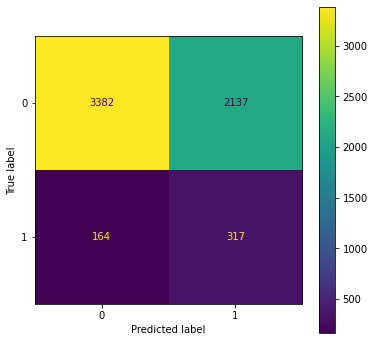

--- ROC AUC ---



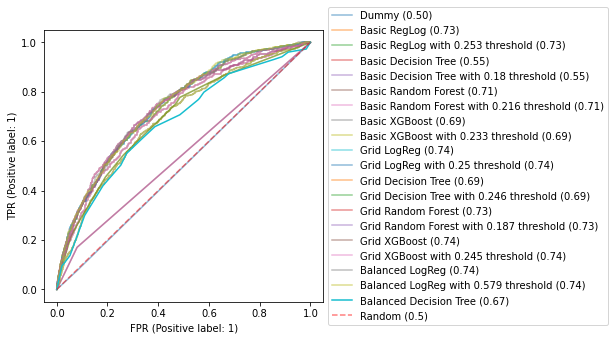

In [115]:
#clf_dt_imb2.fit(X_train_full, y_train_full)
clf_dt_imb2.fit(X_train, y_train)
y_pred_dt_imb = clf_dt_imb2.predict(X_test)
y_pred_proba_dt_imb = clf_dt_imb2.predict_proba(X_test)[:,1]

get_scores("Balanced Decision Tree", y_test, y_pred_dt_imb, y_pred_proba_dt_imb, register=True)

#### Let's use the best threshold

--- Balanced Decision Tree with 0.394 threshold ---

ROC AUC:0.6737616677823238
F1-score:0.21601362862010223
Recall:0.659043659043659

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.61      0.75      5519
Prediction = 1       0.13      0.66      0.22       481

      accuracy                           0.62      6000
     macro avg       0.54      0.64      0.48      6000
  weighted avg       0.89      0.62      0.70      6000

--- Confusion Matrix ---



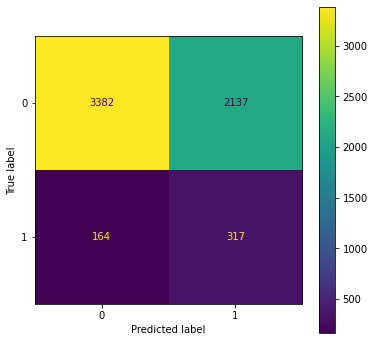

--- ROC AUC ---



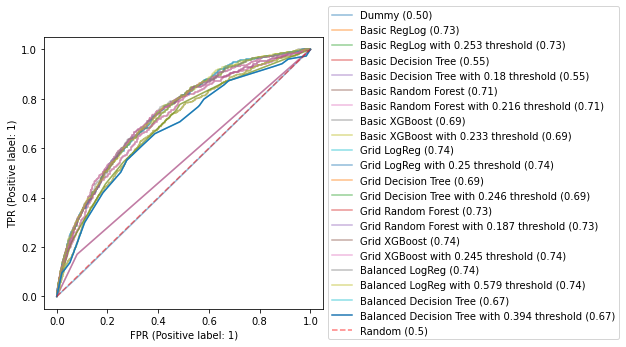

In [116]:
y_pred_proba_dt_imb = clf_dt_imb2.predict_proba(X_test)[:,1]
y_pred_dt_imb = [ 1 if x > best_threshold else 0 for x in y_pred_proba_dt_imb]

get_scores(f"Balanced Decision Tree with {best_threshold} threshold", y_test, y_pred_dt_imb, y_pred_proba_dt_imb, register=True)

## 3. Balanced Random Forest Grid <a class="anchor" id="models_random_forest_balanced"></a> [⇪](#menu)

In [117]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    'n_estimators' :[64, 100, 128, 256, 528]
}

In [118]:
clf_rf_model_imb = RandomForestClassifier(random_state=0, class_weight='balanced')

In [119]:
clf_rf_imb = GridSearchCV(clf_rf_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
#clf_rf_imb.fit(X_train_full, y_train_full)
clf_rf_imb.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [64, 100, 128, 256, 528]},
             scoring='roc_auc', verbose=1)

In [120]:
clf_rf_imb.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'n_estimators': 256}

In [121]:
y_pred_rf_imb = clf_rf_imb.predict(X_test)
y_pred_proba_rf_imb = clf_rf_imb.predict_proba(X_test)[:,1]
get_scores("Balanced Random Forest", y_test, y_pred_rf_imb, y_pred_proba_rf_imb, register=False, simple=True)

--- Balanced Random Forest ---

ROC AUC:0.7286295801425354
F1-score:0.008264462809917356
Recall:0.004158004158004158



#### Let's find the best threshold

In [122]:
f1_value, best_threshold = find_best_threshold(clf_rf_imb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.5834502103786816) for this model is reached with a threshold of 0.584


#### We train a new model using the best parameters

In [123]:
clf_rf_imb2 = RandomForestClassifier( **clf_rf_imb.best_params_, random_state=0, class_weight='balanced')

--- Balanced Random Forest ---

ROC AUC:0.7286295801425354
F1-score:0.008264462809917356
Recall:0.004158004158004158

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.67      0.00      0.01       481

      accuracy                           0.92      6000
     macro avg       0.79      0.50      0.48      6000
  weighted avg       0.90      0.92      0.88      6000

--- Confusion Matrix ---



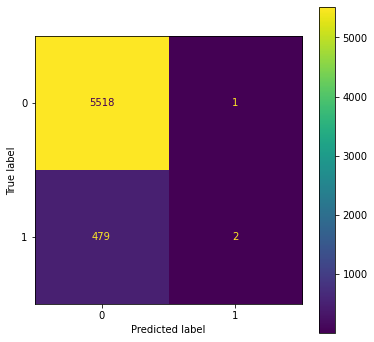

--- ROC AUC ---



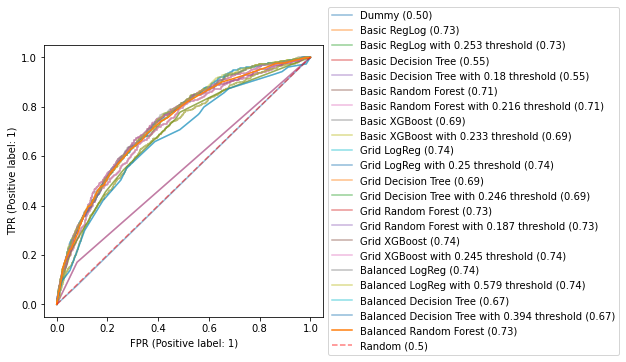

In [124]:
#clf_rf_imb2.fit(X_train_full, y_train_full)
clf_rf_imb2.fit(X_train, y_train)
y_pred_rf_imb = clf_rf_imb2.predict(X_test)
y_pred_proba_rf_imb = clf_rf_imb2.predict_proba(X_test)[:,1]

get_scores("Balanced Random Forest", y_test, y_pred_rf_imb, y_pred_proba_rf_imb, register=True)

#### Let's use the best threshold

--- Balanced Random Forest with 0.584 threshold ---

ROC AUC:0.7286295801425354
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.00      0.00      0.00       481

      accuracy                           0.92      6000
     macro avg       0.46      0.50      0.48      6000
  weighted avg       0.85      0.92      0.88      6000

--- Confusion Matrix ---



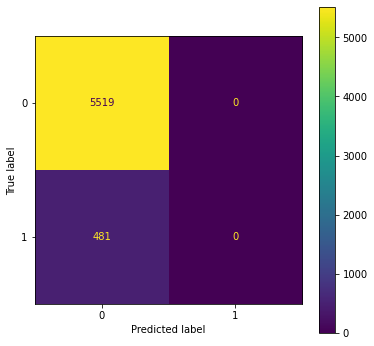

--- ROC AUC ---



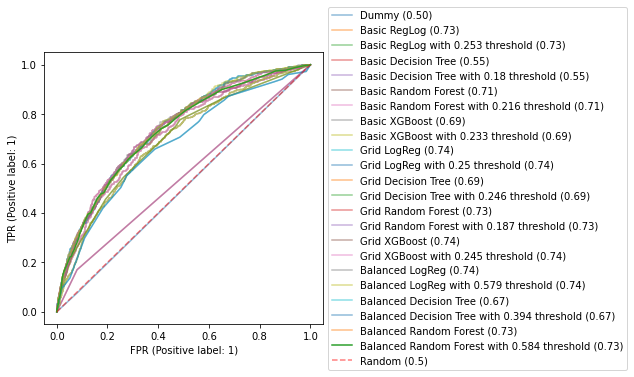

In [125]:
y_pred_proba_rf_imb = clf_rf_imb2.predict_proba(X_test)[:,1]
y_pred_rf_imb = [ 1 if x > best_threshold else 0 for x in y_pred_proba_rf_imb]

get_scores(f"Balanced Random Forest with {best_threshold} threshold", y_test, y_pred_rf_imb, y_pred_proba_rf_imb, register=True)

## 4. Balanced XGBoost Classifier Grid<a class="anchor" id="models_xgboost_balanced"></a> [⇪](#menu)

In [126]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [127]:
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [128]:
from collections import Counter

In [129]:
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]
scale_weigth

11.70289343683839

In [130]:
clf_xgb_model_imb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    nthread=8,
    seed=0,
    verbosity=1,
    scale_pos_weight=scale_weigth
)

In [131]:
clf_xgb_imb = RandomizedSearchCV(clf_xgb_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,
#clf_xgb_imb.fit(X_train_full, y_train_full)
clf_xgb_imb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=1),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc', gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
      

In [132]:
clf_xgb_imb.best_params_

{'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05}

In [133]:
y_pred_xgb_imb = clf_xgb_imb.predict(X_test)
y_pred_proba_xgb_imb = clf_xgb_imb.predict_proba(X_test)[:,1]

get_scores("Balanced XGBoost", y_test, y_pred_xgb_imb, y_pred_proba_xgb_imb, register=False, simple=True)

--- Balanced XGBoost ---

ROC AUC:0.736061475778816
F1-score:0.24843260188087776
Recall:0.659043659043659



#### Let's find the best threshold

In [134]:
f1_value, best_threshold = find_best_threshold(clf_xgb_imb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.321826280623608) for this model is reached with a threshold of 0.5730000000000001


#### We train a new model using the best parameters

In [135]:
clf_xgb_imb2 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    nthread=-1,
    seed=0,
    verbosity=1,
    **clf_xgb_imb.best_params_, 
    random_state=0,
    scale_pos_weight=scale_weigth
)
#clf_xgb_imb2.fit(X_train_full, y_train_full)
clf_xgb_imb2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

--- Balanced XGBoost ---

ROC AUC:0.736061475778816
F1-score:0.24843260188087776
Recall:0.659043659043659

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.80      5519
Prediction = 1       0.15      0.66      0.25       481

      accuracy                           0.68      6000
     macro avg       0.56      0.67      0.52      6000
  weighted avg       0.89      0.68      0.75      6000

--- Confusion Matrix ---



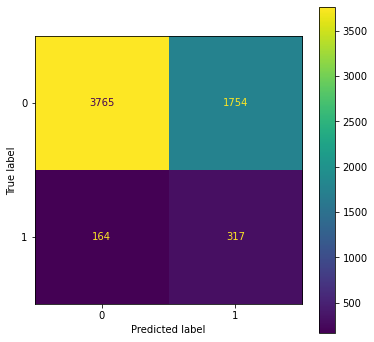

--- ROC AUC ---



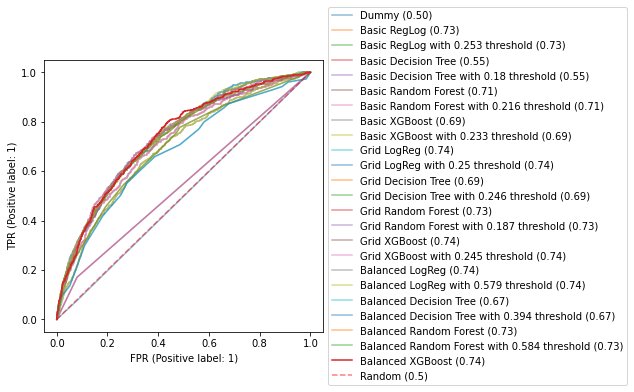

In [136]:
y_pred_xgb_imb = clf_xgb_imb2.predict(X_test)
y_pred_proba_xgb_imb = clf_xgb_imb2.predict_proba(X_test)[:,1]

get_scores("Balanced XGBoost", y_test, y_pred_xgb_imb, y_pred_proba_xgb_imb, register=True)

#### Let's use the best threshold

--- Balanced XGBoost with 0.5730000000000001 threshold ---

ROC AUC:0.736061475778816
F1-score:0.27107438016528923
Recall:0.5114345114345115

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.80      0.87      5519
Prediction = 1       0.18      0.51      0.27       481

      accuracy                           0.78      6000
     macro avg       0.57      0.66      0.57      6000
  weighted avg       0.89      0.78      0.82      6000

--- Confusion Matrix ---



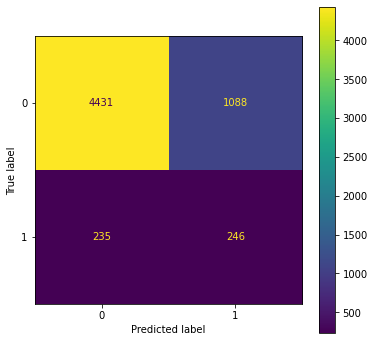

--- ROC AUC ---



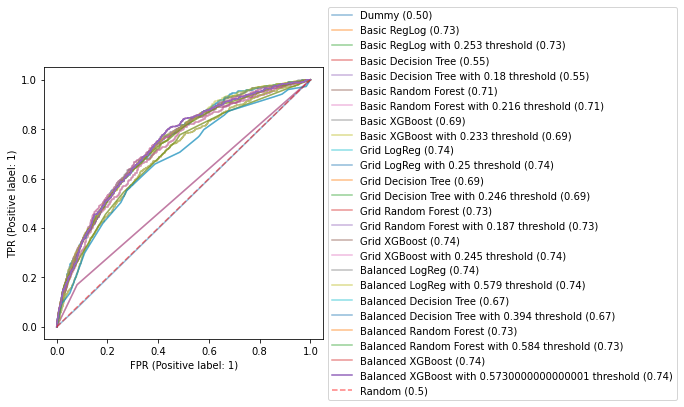

In [137]:
y_pred_proba_xgb_imb = clf_xgb_imb2.predict_proba(X_test)[:,1]
y_pred_xgb_imb = [ 1 if x > best_threshold else 0 for x in y_pred_proba_xgb_imb]

get_scores(f"Balanced XGBoost with {best_threshold} threshold", y_test, y_pred_xgb_imb, y_pred_proba_xgb_imb, register=True)

## 5. Review scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [138]:
scores

,Method,ROC AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN
0,Dummy,0.498056,0.076763,0.851667,0.076605,0.076923,37,5073,446,444
1,Basic RegLog,0.734959,0.004124,0.919500,0.250000,0.002079,1,5516,3,480
2,Basic RegLog with 0.253 threshold,0.734959,0.209913,0.909667,0.351220,0.149688,72,5386,133,409
3,Basic Decision Tree,0.545196,0.163184,0.859833,0.156489,0.170478,82,5077,442,399
4,Basic Decision Tree with 0.18 threshold,0.545196,0.163184,0.859833,0.156489,0.170478,82,5077,442,399
5,Basic Random Forest,0.714428,0.248390,0.727667,0.159480,0.561331,270,4096,1423,211
6,Basic Random Forest with 0.216 threshold,0.714428,0.164596,0.910333,0.325153,0.110187,53,5409,110,428
7,Basic XGBoost,0.691316,0.035019,0.917333,0.272727,0.018711,9,5495,24,472
8,Basic XGBoost with 0.233 threshold,0.691316,0.172202,0.887833,0.210843,0.145530,70,5257,262,411
9,Grid LogReg,0.738148,0.000000,0.919667,0.000000,0.000000,0,5518,1,481


In [139]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('ROC AUC', ascending=False)

,Method,ROC AUC,F1 score,Recall
18,Balanced LogReg with 0.579 threshold,0.739202,0.269414,0.530146
17,Balanced LogReg,0.739031,0.249021,0.661123
16,Grid XGBoost with 0.245 threshold,0.738434,0.223720,0.172557
15,Grid XGBoost,0.738434,0.016393,0.008316
9,Grid LogReg,0.738148,0.000000,0.000000
10,Grid LogReg with 0.25 threshold,0.738148,0.187500,0.130977
24,Balanced XGBoost with 0.5730000000000001 thres...,0.736061,0.271074,0.511435
23,Balanced XGBoost,0.736061,0.248433,0.659044
2,Basic RegLog with 0.253 threshold,0.734959,0.209913,0.149688
1,Basic RegLog,0.734959,0.004124,0.002079


In [140]:
import FreeMobileSMS as sms
sms.send()

JupyterScriptCompleted: Jupyter is waiting

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci